# AlphaZero supervised learning
_Will Kaufman, January 2021_

This is simply to generate training data and do supervised learning so I can test different neural network designs, and to make sure it can actually learn from the data.

In [128]:
import qutip as qt
import numpy as np
import sys
import os
import multiprocessing as mp
import importlib
import matplotlib.pyplot as plt

import torch
import torch.nn.functional as F
from torch import optim
from torch.utils.data import Dataset, DataLoader

In [2]:
sys.path.append(os.path.abspath('..'))
import pulse_sequences as ps
import alpha_zero as az

In [3]:
# importlib.reload(az)
# importlib.reload(ps)

## Define hyperparameters

In [221]:
num_cores = 2  # 32
num_collect_initial = 2  # 5000

max_sequence_length = 48
batch_size = 2048
num_epochs = 10
num_batches = 46

## Define the spin system

In [4]:
delay = 1e-2  # time is relative to chemical shift strength
pulse_width = 1e-3
N = 3  # number of spins
ensemble_size = 5

In [5]:
Utarget = qt.tensor([qt.identity(2)] * N)

In [6]:
rb = az.ReplayBuffer(int(1e5))

## Get data and save to file

In [7]:
def collect_data_no_net(x):
#     print(f'collecting data without network ({x})')
    config = az.Config()
    ps_config = ps.PulseSequenceConfig(N=N, ensemble_size=ensemble_size,
                                       max_sequence_length=max_sequence_length,
                                       Utarget=Utarget,
                                       pulse_width=pulse_width, delay=delay)
    return az.make_sequence(config, ps_config, network=None, rng=ps_config.rng)

In [8]:
with mp.Pool(num_cores) as pool:
    output = pool.map(collect_data_no_net, range(num_collect_initial))
for stat in output:
    az.add_stats_to_buffer(stat, rb)

In [13]:
states, probabilities, values = zip(*rb.buffer)

In [19]:
packed_states = az.pad_and_pack(states)
probabilities = torch.cat(probabilities).view(len(rb), -1)
values = torch.cat(values).view(len(rb), -1)

In [30]:
torch.save(packed_states, 'states.pt')
torch.save(probabilities, 'probabilities.pt')
torch.save(values, 'values.pt')

In [31]:
# len(rb)

## Supervised learning from data

In [33]:
policy = az.Policy()
value = az.Value()

In [36]:
packed_states = torch.load('states.pt')

In [112]:
padded_states = torch.nn.utils.rnn.pad_packed_sequence(packed_states, batch_first=True)

In [46]:
probabilities = torch.load('probabilities.pt')
values = torch.load('values.pt')

In [140]:
class PulseSequenceDataset(Dataset):
    def __init__(self, padded_states, probabilities, values):
        super().__init__()
        self.padded_states = padded_states
        self.probabilities = probabilities
        self.values = values
    
    def __getitem__(self, idx):
        return (self.padded_states[0][idx, ...],
                self.padded_states[1][idx, ...],
                self.probabilities[idx, ...],
                self.values[idx, ...])
    
    def __len__(self):
        return self.values.size(0)

In [141]:
dataset = PulseSequenceDataset(padded_states, probabilities, values)

In [179]:
def collate_fn(data):
    states, lengths, probs, vals = zip(*data)
    states = torch.stack(states)
    lengths = torch.stack(lengths)
    packed_states = torch.nn.utils.rnn.pack_padded_sequence(states, lengths,
                                                            batch_first=True,
                                                            enforce_sorted=False)
    probs = torch.stack(probs)
    vals = torch.stack(vals)
    return packed_states, probs, vals

In [216]:
loader = DataLoader(dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn, drop_last=True)

In [217]:
sample = next(iter(loader))

In [193]:
policy_outputs, _ = policy(sample[0])

(array([ 1308.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.,     0.,     0., 28320., 34896.,
         3552.,     0.,    48.,   528.,   480.,   624.,   720.,  1248.,
         1536.,  1728.,  2256.,  1680.,  2112.,  1104.,  2160.,  1632.,
         1296.,  1776.,  1152.,  1104.,   528.,   624.,   432.,   672.,
          480.,   624.,   384.,   480.,   192.,    96.,     0.,    48.,
           48.,    96.]),
 array([-1.        , -0.92981917, -0.85963833, -0.78945744, -0.7192766 ,
        -0.6490958 , -0.57891494, -0.5087341 , -0.43855324, -0.36837238,
        -0.29819155, -0.2280107 , -0.15782985, -0.08764901, -0.01746817,
         0.05271268,  0.12289353,  0.19307438,  0.2632552 ,  0.33343607,
         0.4036169 ,  0.47379774,  0.5439786 ,  0.61415946,  0.6843403 ,
         0.75452113,  0.82470196,  0.8948828 ,  0.9650637 ,  1.0352445 ,
         1.1054254 ,  1.1756063 ,  1.245787  ,  1.3159679 ,  1.3861487 ,
         1.4563296 ,  1.5265105

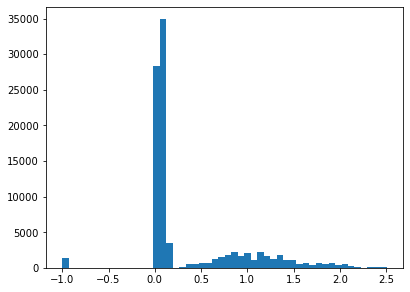

In [78]:
plt.hist(values.numpy(), bins=50)

## Optimize networks with dataset

In [102]:
policy_optimizer = optim.Adam(policy.parameters())
value_optimizer = optim.Adam(value.parameters())

In [226]:
for epoch in range(num_epochs):
    batch_num = 0
    for packed_states, probs, vals in iter(loader):
        print(f'on epoch {epoch}, batch {batch_num}', end='\t')
        policy_optimizer.zero_grad()
        value_optimizer.zero_grad()
        policy_output, _ = policy(packed_states)
        value_outputs, _ = value(packed_states)
        policy_loss = -1 / batch_size * torch.sum(sample[1] * torch.log(policy_output))
        value_loss = F.mse_loss(value_outputs, sample[2])
        policy_loss.backward()
        policy_optimizer.step()
        value_loss.backward()
        value_optimizer.step()
        print(f'policy loss: {policy_loss}, value loss: {value_loss}')
        batch_num += 1

Some commentary... Seems like the training process flatlines with cross entropy loss around 1.6 and MSE loss around 0.3. Things to play around with...

- training for more epochs
- changing network architecture
- changing learning rate etc.

## Pull out well-performing pulse sequences

In [237]:
candidate_idx = values.squeeze() > 2

In [241]:
is_full_sequence = padded_states[1] == 48

In [245]:
candidate_sequences = padded_states[0][candidate_idx * is_full_sequence]

In [297]:
values[candidate_idx * is_full_sequence].squeeze()

tensor([2.0507, 2.1880, 2.0568, 2.3259, 2.0891, 2.0475, 2.0465, 2.0025, 2.0391,
        2.4547, 2.0190, 2.0536, 2.0163, 2.4376, 2.1477, 2.0211, 2.0812, 2.0972,
        2.0765, 2.1756, 2.5090, 2.0155, 2.1318])

In [302]:
candidate_sequences.shape

torch.Size([23, 48, 6])

In [293]:
ps_config = ps.PulseSequenceConfig(N=3, ensemble_size=10, max_sequence_length=48, Utarget=Utarget)

In [308]:
candidates = []
for i in range(candidate_sequences.size(0)):
    sequence = list(torch.argmax(candidate_sequences[i,...], dim=1).numpy()[1:] - 1)
    sequence += ps.get_valid_time_suspension_pulses(sequence, num_pulses=5, sequence_length=48)
    fidelity = ps.get_mean_fidelity(sequence, Utarget, ps_config.pulses_ensemble)
    reward = -np.log10(1 - fidelity + 1e-200)
    candidates.append((sequence, reward))

In [318]:
candidates.sort(key=lambda x: -x[1])

In [322]:
for i in range(5):
    print(candidates[i][1])

2.2353464312128435
2.1204414626672023
2.0665367613756347
2.000438338687582
1.9058772164486646


In [324]:
# compare with yxx48 sequence
fidelity = ps.get_mean_fidelity(ps.yxx48, Utarget, ps_config.pulses_ensemble)
reward = -np.log10(1 - fidelity + 1e-200)

In [325]:
reward

3.45639989073415